In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import scipy
from scipy import optimize, stats

In [3]:
import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [5]:
from pingouin import rm_anova

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [7]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [8]:
dir_root = join('/mnt/ext6/GL/fmri_data')
dir_stat = join(dir_root, 'stats')
dir_mask = join(dir_root, 'masks')

In [9]:
list_subj = [
    'GL03', 'GL04', 'GL05', 'GL06', 'GL07'
    , 'GL08', 'GL09', 'GL10', 'GL11', 'GL12'
    , 'GL14', 'GL15', 'GL16', 'GL17', 'GL18'
    , 'GL19', 'GL20', 'GL21', 'GL22', 'GL24'
    , 'GL25', 'GL26', 'GL27', 'GL29'
]

In [10]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

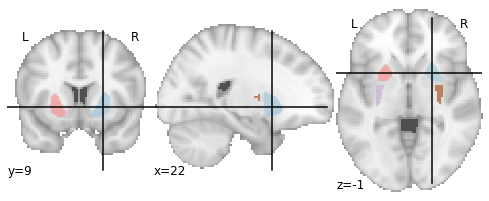

In [11]:
img_putamen = join(dir_mask, 'mask.putamen_4parts.nii')
nilearn.plotting.plot_roi(img_putamen, cmap='Paired')

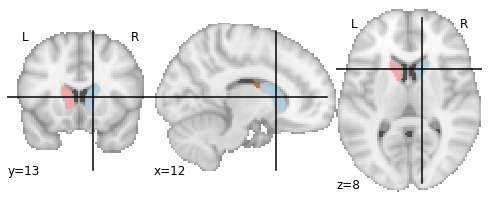

In [12]:
img_caudate = join(dir_mask, 'mask.caudate_4parts.nii')
nilearn.plotting.plot_roi(img_caudate, cmap='Paired')

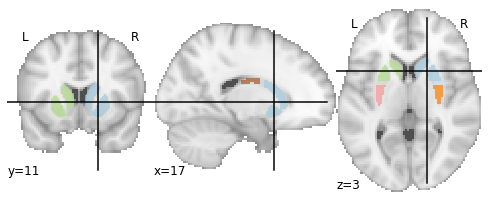

In [13]:
img_striatum = join(dir_mask, 'mask.striatum_6parts.nii')
nilearn.plotting.plot_roi(img_striatum, cmap='Paired')

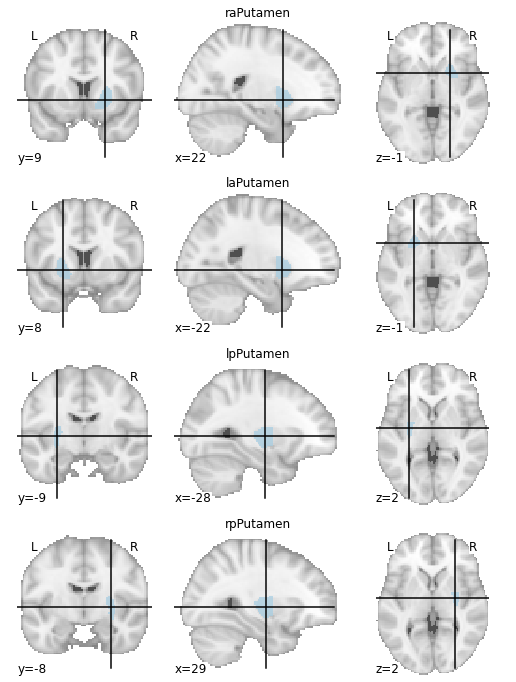

In [15]:
labels = ['raPutamen', 'laPutamen', 'lpPutamen', 'rpPutamen']

fig, axs = plt.subplots(nrows=len(labels), figsize=(9,12))
for ii, label in enumerate(labels):
    ax = axs[ii]
    tmp = nilearn.image.math_img(img1=img_putamen, formula='img1==%d'%(ii+1))
    nilearn.plotting.plot_roi(tmp, cmap='Paired', axes=ax)
    ax.set_title(label)

# fig.tight_layout()

---

In [14]:
dh = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])
dh

,subj,source,ROI,beta


- Putamen

In [15]:
tmp = nilearn.image.math_img(img1=img_putamen, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==1)')
img_aPutamen = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==2)')

tmp = nilearn.image.math_img(img1=img_putamen, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==3)')
img_pPutamen = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==4)')

img_Putamen = nilearn.image.math_img(img1=img_aPutamen, img2=img_pPutamen, formula='img1+img2*2')

In [16]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_Putamen, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['aPutamen', 'pPutamen']
)

In [17]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Coef.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
df

,subj,source,ROI,beta
0,GL03,reward,aPutamen,0.292649
1,GL03,reward,pPutamen,0.283536
2,GL03,move-stop,aPutamen,0.054021
3,GL03,move-stop,pPutamen,0.060376
4,GL04,reward,aPutamen,0.130735
...,...,...,...,...
91,GL27,move-stop,pPutamen,-0.074127
92,GL29,reward,aPutamen,0.492906
93,GL29,reward,pPutamen,0.400000
94,GL29,move-stop,aPutamen,-0.004101


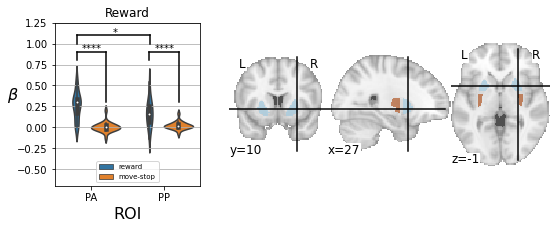

In [20]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
ax = sns.violinplot(
    data=df, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.set(title='Reward')
ax.legend(loc='lower center', fontsize=7)
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_ylim([-.7,1.25])
ax.set_xlabel('ROI', fontsize=16)
ax.set_xlim([-.5, 1.5])
ax.set_xticklabels(['PA', 'PP'])
ax.grid(axis='y')

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aPutamen')].beta
b = df[(df.source=='reward')&(df.ROI=='pPutamen')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[1.,1.1], 'k-')
ax.plot([.81,.81],[1.,1.1], 'k-')
ax.plot([-.2,.81],[1.1,1.1], 'k-')
ax.text(.3,1.1, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aPutamen')].beta
b = df[(df.source=='move-stop')&(df.ROI=='aPutamen')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[.8,.9], 'k-')
ax.plot([.2,.2],[.3,.9], 'k-')
ax.plot([-.2,.2],[.9,.9], 'k-')
ax.text(-.125,.9, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='pPutamen')].beta
b = df[(df.source=='move-stop')&(df.ROI=='pPutamen')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([.8,.8],[.8,.9], 'k-')
ax.plot([1.205,1.205],[.3,.9], 'k-')
ax.plot([.8,1.205],[.9,.9], 'k-')
ax.text(.875,.9, convert_pvalue_to_asterisks(pval))

# fig.tight_layout()
ax = axs[1]
nilearn.plotting.plot_roi(img_Putamen, cmap='Paired', cut_coords=(27,10,-1), axes=ax)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.putamen.violinplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

- Caudate

In [21]:
tmp = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==1)')
img_aCaudate = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==2)')

tmp = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==3)')
img_pCaudate = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==4)')

img_Caudate = nilearn.image.math_img(img1=img_aCaudate, img2=img_pCaudate, formula='img1+img2*2')

In [22]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_Caudate, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['aCaudate', 'pCaudate']
)

In [23]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Coef.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
df

,subj,source,ROI,beta
0,GL03,reward,aCaudate,0.299908
1,GL03,reward,pCaudate,0.430838
2,GL03,move-stop,aCaudate,0.031746
3,GL03,move-stop,pCaudate,0.035592
4,GL04,reward,aCaudate,0.073800
...,...,...,...,...
91,GL27,move-stop,pCaudate,-0.029589
92,GL29,reward,aCaudate,0.274921
93,GL29,reward,pCaudate,0.184790
94,GL29,move-stop,aCaudate,-0.005161


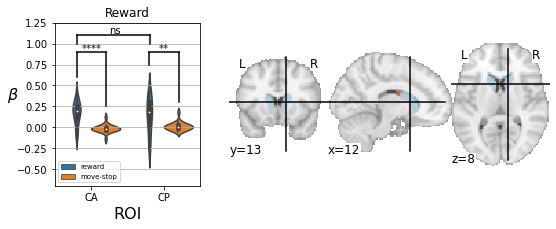

In [27]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
ax = sns.violinplot(
    data=df, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.set(title='Reward')
ax.legend(loc='lower left', fontsize=7)
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_ylim([-.7,1.25])
ax.set_xlabel('ROI', fontsize=16)
ax.set_xlim([-.5, 1.5])
ax.set_xticklabels(['CA', 'CP'])
ax.grid(axis='y')

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aCaudate')].beta
b = df[(df.source=='reward')&(df.ROI=='pCaudate')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[1.,1.1], 'k-')
ax.plot([.81,.81],[1.,1.1], 'k-')
ax.plot([-.2,.81],[1.1,1.1], 'k-')
ax.text(.25,1.125, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aCaudate')].beta
b = df[(df.source=='move-stop')&(df.ROI=='aCaudate')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[.6,.9], 'k-')
ax.plot([.2,.2],[.25,.9], 'k-')
ax.plot([-.2,.2],[.9,.9], 'k-')
ax.text(-.125,.9, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='pCaudate')].beta
b = df[(df.source=='move-stop')&(df.ROI=='pCaudate')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([.8,.8],[.75,.9], 'k-')
ax.plot([1.205,1.205],[.3,.9], 'k-')
ax.plot([.8,1.205],[.9,.9], 'k-')
ax.text(.925,.9, convert_pvalue_to_asterisks(pval))

# fig.tight_layout()
ax = axs[1]
nilearn.plotting.plot_roi(img_Caudate, cmap='Paired', cut_coords=(12,13,8), axes=ax)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.caudate.violinplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

- Striatum

In [28]:
tmp = nilearn.image.math_img(img1=img_striatum, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==1)')
img_aStriatum = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==2)')

tmp = nilearn.image.math_img(img1=img_striatum, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==3)')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==4)')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==5)')
img_pStriatum = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==6)')

img_Striatum = nilearn.image.math_img(img1=img_aStriatum, img2=img_pStriatum, formula='img1+img2*2')

In [29]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_Striatum, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['aStriatum', 'pStriatum']
)

In [30]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Coef.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
df

,subj,source,ROI,beta
0,GL03,reward,aStriatum,0.296272
1,GL03,reward,pStriatum,0.306897
2,GL03,move-stop,aStriatum,0.042904
3,GL03,move-stop,pStriatum,0.056445
4,GL04,reward,aStriatum,0.102320
...,...,...,...,...
91,GL27,move-stop,pStriatum,-0.067063
92,GL29,reward,aStriatum,0.384113
93,GL29,reward,pStriatum,0.365870
94,GL29,move-stop,aStriatum,-0.004630


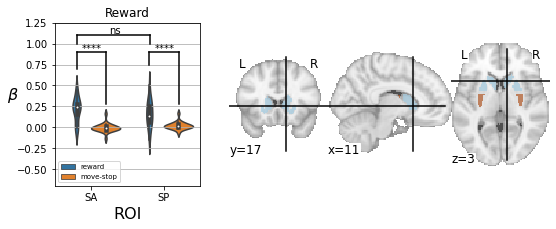

In [37]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
ax = sns.violinplot(
    data=df, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.set(title='Reward')
ax.legend(loc='lower left', fontsize=7)
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_ylim([-.7,1.25])
ax.set_xlabel('ROI', fontsize=16)
ax.set_xlim([-.5, 1.5])
ax.set_xticklabels(['SA', 'SP'])
ax.grid(axis='y')

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aStriatum')].beta
b = df[(df.source=='reward')&(df.ROI=='pStriatum')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[1.,1.1], 'k-')
ax.plot([.81,.81],[1.,1.1], 'k-')
ax.plot([-.2,.81],[1.1,1.1], 'k-')
ax.text(.25,1.125, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aStriatum')].beta
b = df[(df.source=='move-stop')&(df.ROI=='aStriatum')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[.7,.9], 'k-')
ax.plot([.2,.2],[.28,.9], 'k-')
ax.plot([-.2,.2],[.9,.9], 'k-')
ax.text(-.125,.9, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='pStriatum')].beta
b = df[(df.source=='move-stop')&(df.ROI=='pStriatum')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([.8,.8],[.74,.9], 'k-')
ax.plot([1.205,1.205],[.28,.9], 'k-')
ax.plot([.8,1.205],[.9,.9], 'k-')
ax.text(.875,.9, convert_pvalue_to_asterisks(pval))

# fig.tight_layout()
ax = axs[1]
nilearn.plotting.plot_roi(img_Striatum, cmap='Paired', cut_coords=(11,17,3), axes=ax)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.striatum.violinplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---

In [38]:
dh

,subj,source,ROI,beta
0,GL03,reward,aPutamen,0.292649
1,GL03,reward,pPutamen,0.283536
2,GL03,move-stop,aPutamen,0.054021
3,GL03,move-stop,pPutamen,0.060376
4,GL04,reward,aPutamen,0.130735
...,...,...,...,...
91,GL27,move-stop,pStriatum,-0.067063
92,GL29,reward,aStriatum,0.384113
93,GL29,reward,pStriatum,0.365870
94,GL29,move-stop,aStriatum,-0.004630


Text(0.5, 0, 'ROI')

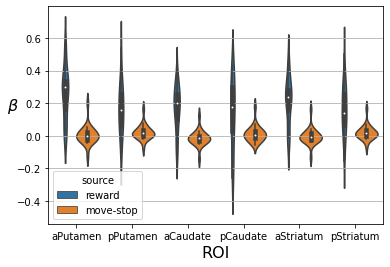

In [46]:
fig, ax = plt.subplots()

ax = sns.violinplot(
    data=dh, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.grid(axis='y')
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_xlabel('ROI', fontsize=16)

In [41]:
rm_anova(data=dh
         , dv= 'beta'
         , subject='subj'
         , within=['source','ROI']
         , effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,source,2.344453,1,23,2.344453,32.044786,9.198834e-06,0.000009,0.582158,1.000000
1,ROI,0.100660,5,115,0.020132,7.167242,7.158991e-06,0.001358,0.237584,0.438021
2,source * ROI,0.146725,5,115,0.029345,9.650566,1.029781e-07,0.000393,0.295571,0.384081
